# Colossal-AI: A Unified Deep Learning System For Large-Scale Parallel Training

<p><b>Requirements:</b>

PyTorch >= 1.11 and PyTorch <= 2.1<br/>
Python >= 3.7<br/>
CUDA >= 11.0<br/>
NVIDIA GPU Compute Capability >= 7.0 (V100/RTX20 and higher)<br/>
Linux OS</p>

## Overview
Colossal-AI is an open-source deep learning system designed for efficient, large-scale parallel training of neural network models. Developed to simplify the complexities involved in training large models across multiple GPUs and nodes, Colossal-AI provides a high-level interface and toolkits that integrate seamlessly with popular deep learning frameworks like PyTorch. It facilitates the implementation of various parallelism strategies, such as tensor parallelism, data parallelism, pipeline parallelism, and hybrid parallelism, thereby enabling researchers and practitioners to scale their models beyond the constraints of single-device capacities.

## Purpose
The primary purpose of Colossal-AI is to make the massive-scale model training accessible for general public, which was previously limited to well-resourced organizations due to hardware and complexity constraints. It aims to provide an easy-to-use, flexible, and efficient platform that allows users to train extremely large models with reduced coding overhead and optimized resource usage. By abstracting the underlying complexity of parallel computation, it enables users to focus more on model development rather than on parallelization details.

## Application
Colossal-AI is applicable in scenarios where training large models is essential, such as in natural language processing (e.g., training transformer models like GPT and BERT), computer vision, and other domains requiring significant computational power and memory. It supports various applications, ranging from academic research to industrial deployments, where the training of large and complex models is crucial for advancing state-of-the-art performances and developing innovative solutions.

## Libraries Used

1. PyTorch and torchvision: Used for building and training neural network models, along with data preprocessing and augmentation for vision tasks.
1. torch.distributed: Facilitates distributed computing, allowing PyTorch to communicate across multiple nodes or GPUs.
1. torch.optim, torch.nn.functional, and others: Provide various optimization algorithms and functional interfaces for neural network training.
1. colossalai: Offers tools and components specifically designed for scaling up model training, such as HybridAdam for efficient optimization and Booster with TorchDDPPlugin for enhanced data-parallel training.
1. matplotlib, seaborn, numpy: Utilized for data visualization and numerical operations, essential for analyzing and presenting model performance.
1. torchmetrics and sklearn.metrics: These libraries are employed to measure and report various model performance metrics, such as precision, recall, ROC curves, and confusion matrices, essential for evaluating the effectiveness of trained models.

### Import Required Packages

In [2]:
import os
import time
import warnings

import torch
import torch.distributed as dist
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

import colossalai
from colossalai.accelerator import get_accelerator
from colossalai.booster import Booster
from colossalai.booster.plugin import TorchDDPPlugin
from colossalai.cluster import DistCoordinator
from colossalai.nn.optimizer import HybridAdam

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

warnings.filterwarnings("ignore")

### Set up distributed training environment variables

In [3]:
os.environ["RANK"] = "0"  # Rank of the current process in distributed environment
os.environ["LOCAL_RANK"] = "0"  # Local rank of the current process
os.environ["WORLD_SIZE"] = "1"  # Total number of processes
os.environ["MASTER_ADDR"] = "localhost"  # Address of the master node
os.environ["MASTER_PORT"] = "1234"  # Port for communication

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define Hyperparameters

In [5]:
# Hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
GAMMA = 0.3

### Initialize ColossalAI, Plugin and Booster

In [6]:
colossalai.launch_from_torch(config={}) #comment this line if already launched
coordinator = DistCoordinator()

plugin = TorchDDPPlugin()
booster = Booster(plugin=plugin)

[04/17/24 18:47:33] INFO     colossalai - colossalai - INFO:                                                       
                             /user/ngupta22/.local/lib/python3.9/site-packages/colossalai/initialize.py:67 launch

                    INFO     colossalai - colossalai - INFO: Distributed environment is initialized, world size: 1

### Transformation and Dataloaders 

In [7]:
# Transform
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset
data_path = os.environ.get("DATA", "./data")
train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, transform=transform_test, download=True)

# Data loader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# MNIST dataset for ColossalAI
data_path = os.environ.get("DATA", "./dataColossalAI")
with coordinator.priority_execution():
    train_dataset_Col = torchvision.datasets.MNIST(
        root=data_path, train=True, transform=transform_train, download=True
    )
    test_dataset_Col = torchvision.datasets.MNIST(
        root=data_path, train=False, transform=transform_test, download=True
    )

# Data loader for ColossalAI
train_dataloader_Col = plugin.prepare_dataloader(train_dataset_Col, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader_Col = plugin.prepare_dataloader(test_dataset_Col, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

### Grayscale or RGB Image check

In [8]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in train_dataloader:
    print(image.shape[1])
    break

1


### Sample Images

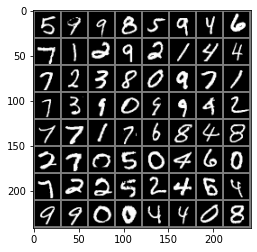

5 - five 9 - nine 9 - nine 8 - eight 5 - five 9 - nine 4 - four 6 - six 7 - seven 1 - one 2 - two 9 - nine 2 - two 1 - one 4 - four 4 - four 7 - seven 2 - two 3 - three 8 - eight 0 - zero 9 - nine 7 - seven 1 - one 7 - seven 3 - three 9 - nine 0 - zero 9 - nine 9 - nine 4 - four 2 - two 7 - seven 7 - seven 1 - one 7 - seven 6 - six 8 - eight 4 - four 8 - eight 2 - two 7 - seven 0 - zero 5 - five 0 - zero 4 - four 6 - six 0 - zero 7 - seven 2 - two 2 - two 5 - five 2 - two 4 - four 6 - six 4 - four 9 - nine 9 - nine 0 - zero 0 - zero 4 - four 4 - four 0 - zero 8 - eight


In [9]:
classes = train_dataset.classes

# Print batch size sample images from dataset
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

### Define Model Architecture

In [10]:
class VGG13(nn.Module):
    def __init__(self, dropoutAdd=False):
        super(VGG13, self).__init__()
        self.dropoutAdd = dropoutAdd

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully-connected layers
        self.fc6 = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5) if self.dropoutAdd else nn.Identity(),
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5) if self.dropoutAdd else nn.Identity(),
        )

        self.fc8 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        return x

In [11]:
modelVGG = VGG13(dropoutAdd=True).to(device)
print("\nModel Architecture:\n")
print(modelVGG)


Model Architecture:

VGG13(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, ke

### Prepare Criterion, Optimizer, Learning Rate Scheduler

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelVGG.parameters(), lr=LEARNING_RATE)
optimizer_Col = HybridAdam(modelVGG.parameters(), lr=LEARNING_RATE)
lr_scheduler = MultiStepLR(optimizer, milestones=[20, 40, 60, 80], gamma=GAMMA)

[extension] Compiling the JIT cpu_adam_x86 kernel during runtime now
[extension] Time taken to compile cpu_adam_x86 op: 0.39098334312438965 seconds
[extension] Compiling the JIT fused_optim_cuda kernel during runtime now
[extension] Time taken to compile fused_optim_cuda op: 0.20939874649047852 seconds


### Define Model Training

In [13]:
def modelTraining(
    epochs: int,
    model: nn.Module,
    optimizer: Optimizer,
    criterion: nn.Module,
    lr_scheduler: MultiStepLR,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    booster: Booster,
    coordinator: DistCoordinator,
    colossalAI = False,
):

    startTime = time.time()

    training_loss_plt_arr = []
    testing_loss_plt_arr = []

    for epoch in range(epochs):
        
        # Training Loss
        model.train()
        train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            if colossalAI:
                booster.backward(loss, optimizer)
            else:
                loss.backward()
            
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

        # Compute average training loss for the epoch
        avg_train_loss = train_loss / len(train_dataloader)
        training_loss_plt_arr.append(avg_train_loss)

        # Testing Loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate testing loss
                test_loss += loss.item()

        # Compute average testing loss for the epoch
        avg_test_loss = test_loss / len(test_dataloader)
        testing_loss_plt_arr.append(avg_test_loss)

        # Print log info
        if (epoch+1) % 2 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        lr_scheduler.step()

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)
    
    if colossalAI:
        print(f"\nTime to train with colossalAI: {minutes}min {seconds}sec")
    else:
        print(f"\nTime to train without colossalAI: {minutes}min {seconds}sec")

    return training_loss_plt_arr, testing_loss_plt_arr


### Plot Losses

In [14]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, testing_loss_plt_arr):
    epochs = range(1, len(training_loss_plt_arr) + 1)
    plt.plot(epochs, training_loss_plt_arr, label='Training Loss', color='red')
    plt.plot(epochs, testing_loss_plt_arr, label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Testing loss')
    plt.legend()
    plt.show()


### Define Model Testing

In [15]:
def loadersAccuracy(model, loader, colossalAI):
    
    model.eval()
    correct = torch.zeros(1, dtype=torch.int64, device=get_accelerator().get_current_device()) if colossalAI else 0
    total = torch.zeros(1, dtype=torch.int64, device=get_accelerator().get_current_device()) if colossalAI else 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []
    
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.flatten()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        trueLabels.extend(labels.tolist())
        predictedLabels.extend(predicted.tolist())
        
        # ROC
        preds = F.softmax(outputs, dim=1)
        trueLabelsROC.extend(labels.tolist())
        predictedLabelsROC.extend(preds.tolist())
        
    if colossalAI:
        dist.all_reduce(correct)
        dist.all_reduce(total)
        accuracy = (correct.item() / total.item()) * 100
    else:
        accuracy = (correct / total) * 100
    
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC
    

def perfEvaluation(model, train_dataloader, test_dataloader, colossalAI = False):

    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(model, test_dataloader, colossalAI)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    train_accuracy, _, _, _, _ = loadersAccuracy(model, train_dataloader, colossalAI)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Test']
    accuracies = [train_accuracy, test_accuracy]
    bars = plt.bar(labels, accuracies, color=['red', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    # Adjust text position to be above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=10)
    test_predictedLabelsROC = test_predictedLabelsROC.to(device)
    test_trueLabelsROC = test_trueLabelsROC.to(device)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

### Model Evaluation without Colossal AI

Model Evaluation without Colossal AI
Epoch [2/20], Train Loss: 0.0493, Test Loss: 0.0486
Epoch [4/20], Train Loss: 0.0319, Test Loss: 0.0326
Epoch [6/20], Train Loss: 0.0242, Test Loss: 0.0342
Epoch [8/20], Train Loss: 0.0195, Test Loss: 0.0460
Epoch [10/20], Train Loss: 0.0185, Test Loss: 0.0273
Epoch [12/20], Train Loss: 0.0139, Test Loss: 0.0357
Epoch [14/20], Train Loss: 0.0133, Test Loss: 0.0447
Epoch [16/20], Train Loss: 0.0116, Test Loss: 0.0326
Epoch [18/20], Train Loss: 0.0099, Test Loss: 0.0374
Epoch [20/20], Train Loss: 0.0115, Test Loss: 0.0303
Finished Training

Time to train without colossalAI: 8min 21sec


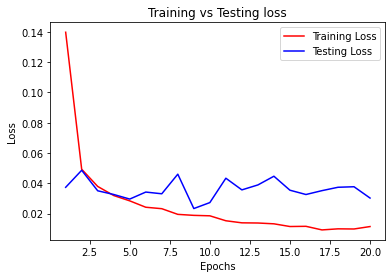

Accuracy on the testing dataset = 99.42
Precision = 0.99
Recall = 0.99
Fscore = 0.99


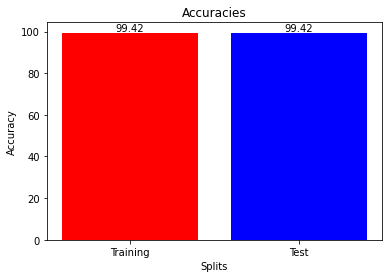

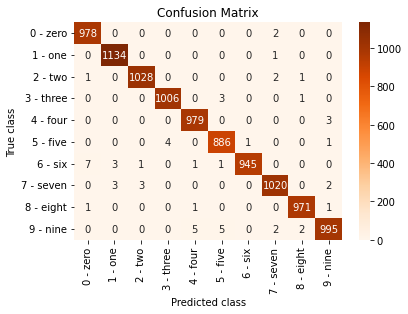

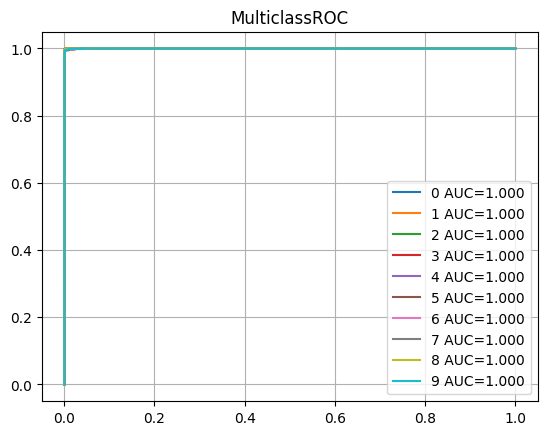

In [16]:
print("====================================")
print("Model Evaluation without Colossal AI")
print("====================================")
training_loss_plt_arr, testing_loss_plt_arr = modelTraining(NUM_EPOCHS, modelVGG, optimizer, 
                                                            criterion, lr_scheduler, train_dataloader, 
                                                            test_dataloader, booster, 
                                                            coordinator, colossalAI = False)
LossesPlot(training_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(modelVGG, train_dataloader, test_dataloader, colossalAI = False)

### Boost with ColossalAI

In [17]:
model_Col, optimizer_Col, criterion_Col, _, lr_scheduler_Col = booster.boost(
    model=modelVGG, optimizer=optimizer_Col, criterion=criterion, lr_scheduler=lr_scheduler
)

### Model Evaluation with Colossal AI

Model Evaluation with Colossal AI
Epoch [2/20], Train Loss: 0.0113, Test Loss: 0.0318
Epoch [4/20], Train Loss: 0.0049, Test Loss: 0.0426
Epoch [6/20], Train Loss: 0.0046, Test Loss: 0.0396
Epoch [8/20], Train Loss: 0.0054, Test Loss: 0.0452
Epoch [10/20], Train Loss: 0.0052, Test Loss: 0.0362
Epoch [12/20], Train Loss: 0.0086, Test Loss: 0.0519
Epoch [14/20], Train Loss: 0.0054, Test Loss: 0.0421
Epoch [16/20], Train Loss: 0.0110, Test Loss: 0.0511
Epoch [18/20], Train Loss: 0.0038, Test Loss: 0.0460
Epoch [20/20], Train Loss: 0.0064, Test Loss: 0.0447
Finished Training

Time to train with colossalAI: 8min 4sec


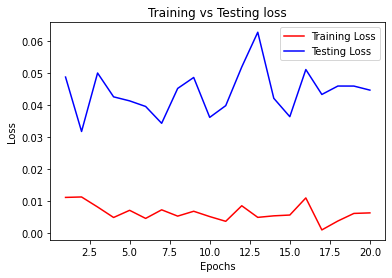

Accuracy on the testing dataset = 99.32
Precision = 0.99
Recall = 0.99
Fscore = 0.99


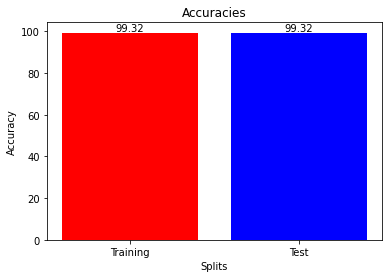

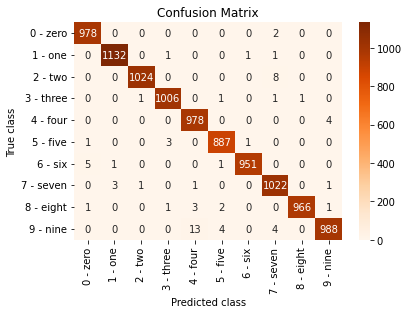

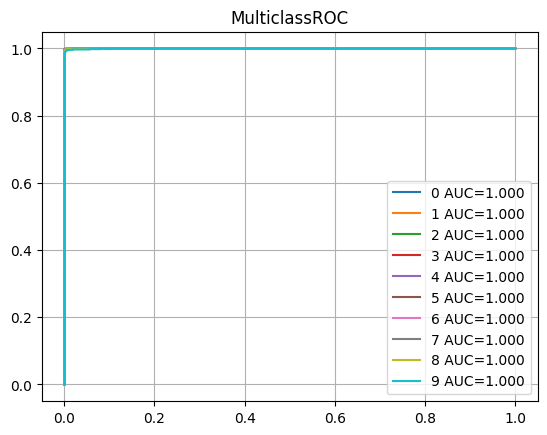

In [18]:
print("=================================")
print("Model Evaluation with Colossal AI")
print("=================================")
training_loss_plt_arr, testing_loss_plt_arr = modelTraining(NUM_EPOCHS, model_Col, optimizer_Col, 
                                                            criterion_Col, lr_scheduler_Col, 
                                                            train_dataloader_Col, test_dataloader_Col, 
                                                            booster, coordinator, colossalAI = True)
LossesPlot(training_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model_Col, train_dataloader_Col, test_dataloader_Col, colossalAI = True)

### Time to Train

- **Without colossalAI:** 8min 21sec
- **With colossalAI:** 8min 4sec


# Observations

1. **Efficiency Gains Over Multiple Epochs**: The experiment results reveal that the model trained with Colossal-AI finished slightly faster than the traditionally trained model when run over an extended period (20 epochs). This suggests that Colossal-AI can enhance training efficiency over many iterations, despite the modest time difference.

2. **Impact of Dataset Simplicity on Parallel Training**: Although VGG13 is a substantial model, the simplicity and small size of the MNIST dataset mean that the benefits of parallel training processes are not maximized. Generally, parallelization shows more substantial advantages with larger, more complex datasets or deeper models that demand significant computational power.

3. **Hardware Limitations and Parallelization Efficiency**: With only 2 GPUs and a limited core setup, the potential of Colossal-AI’s parallelization capabilities might not be entirely exploited. Colossal-AI typically performs best when scaled across a larger number of GPUs and nodes. In scenarios involving smaller hardware setups, the overhead from setting up distributed computations and synchronizing data may offset the gains from parallel processing, limiting the improvement in training times.

### References

1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://scikit-learn.org/stable/
1. https://seaborn.pydata.org/
1. https://pytorch.org/tutorials/
1. https://pytorch.org/vision/main/models/vision_transformer.html
1. https://colossalai.org/docs/get_started/installation/
1. https://github.com/hpcaitech/ColossalAI
1. https://github.com/hpcaitech/ColossalAI/blob/main/examples/images/resnet/train.py
1. Data Loading, VGG13 Model Architecture, Model Training and Testing is based on CSE 676 Deep Learning Assignment 1 Part 1 and Bonus submission by Nikhil Gupta